# Exploring data

Retrieving datasets, filtering, pivoting and merging

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
pd.options.display.max_columns = None

In [2]:
df = pd.read_pickle('../data/combined_df.pkl')
happiness = pd.read_pickle("../data/happiness.pkl")

There is a lot of missing data for each year in most of the countries so we decided to drop some of those countries and keep the ones that contain most of the data.
Later on we could also go back to some of the countries, some of them are countries that are labaled as underdeveloped so the lack of information on indicators such as `4.1.2 Completion rate (%)` or `8.5.2 Unemployment rate (%) - Male, Persons with disability` is understandable. This knowledge could also explain the `happiness rating` that has been assigned to those countries. 

In [3]:
columns_to_check_nan = df.columns[7:]

for country in df['Country'].unique():
    nan_data = df.loc[df['Country'] == country, columns_to_check_nan].isnull().sum()
    nan_columns = nan_data[nan_data > 0].index
    
    if not nan_columns.empty:
        #print(f"Country: {country}")
        for column in nan_columns:
            nan_years = df.loc[(df['Country'] == country) & df[column].isnull(), 'Year'].tolist()
            nan_count = nan_data[column]
            #print(f"  - Column with NaN: {column}")
            #print(f"    - Number of NaN values: {nan_count}")

Decided to drop, for now, the columns that belong to the Indicator `Employed population below international poverty line (%)` since we can analyze the poverty rate (%) and then break it down for further analysis with the `Unemplyment rate`

In [4]:
employed_poverty_rate = df.filter(like='Employed').columns
#employed_poverty_rate.loc[:, 'Country'] = df['Country'].copy()
#employed_poverty_rate.loc[:, 'Year'] = df['Year'].copy()
#employed_poverty_rate.isnull().sum()

df.drop(columns=employed_poverty_rate, inplace=True)

Decided to look into the columns that have the most missing data out of all the indicators.
There seems to be a lot of missing data (more than half) in the suicide mortality rate so I want to check next if this corresponds to every year for every country or if this is data that was not taken in consideration over previous years. 
If this would be the case we would take into consideration the years were the suicide mortality rate was present since we believe this would have a big impact when rating the happiness in a country.

In [5]:
group_indicators = ['1.1.1', '3.4.2', '4.1.2', '8.5.2']

for indicator in group_indicators:
    columns = df.filter(like=indicator).columns
    nan_counts = df[columns].isna().sum().sort_values(ascending=False)
    
    top_5_group = nan_counts.head(5)
    
    print(f"\nTop 5 columns with the highest number of NaN values in Group {indicator}:")
    print(top_5_group)


Top 5 columns with the highest number of NaN values in Group 1.1.1:
(value, 1.1.1 Population below international poverty line (%), Rural)          466
(value, 1.1.1 Population below international poverty line (%), Urban)          456
(value, 1.1.1 Population below international poverty line (%), 15-64 years)    447
(value, 1.1.1 Population below international poverty line (%), <15 years)      446
(value, 1.1.1 Population below international poverty line (%), 65+ years)      445
dtype: int64

Top 5 columns with the highest number of NaN values in Group 3.4.2:
(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Female)     447
(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Male)       447
(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), average)    447
dtype: int64

Top 5 columns with the highest number of NaN values in Group 4.1.2:
(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 4)              614
(v

In [6]:
group_patterns = ['1.1.1', '3.4.2', '4.1.2', '8.5.2']

for group_pattern in group_patterns:
    group_columns = df.filter(like=group_pattern).columns
    
    countries_with_no_missing_data = []

    for country in df['Country'].unique():
        years_with_no_missing_data = df.loc[df['Country'] == country, ['Year'] + list(group_columns)].dropna()

        if not years_with_no_missing_data.empty:
            countries_with_no_missing_data.append((country, years_with_no_missing_data['Year'].tolist()))

    #print(f"Countries with no missing data for any year in Group {group_pattern}:\n")
    #for country, no_missing_years in countries_with_no_missing_data:
        #print(f"- {country}: Years with no missing data: {no_missing_years}")

# UNCOMMENT THE LINES ABOVE WHEN RUNNING THE FILE --> did this to avoid having an giant notebook for now

Most of the countries have data for year 2019. Therefore, we will focus on countries with the least NaN entries in the year 2019, to ensure maximum data availability. The countries are *Bolivia, Dominican Republic, Honduras, Thailand, and Zimbabwe*. 

In [7]:
df_2019  = df[df['Year']==2019]
nan_entries_by_country = df_2019.set_index('Country').isna().sum(axis=1).sort_values()
countries = nan_entries_by_country[:5].index.tolist()

selected_countries_df = df[(df['Country'].isin(countries)) & (df['Year'] == 2019)]
selected_countries_df

,Country,Year,Happiness Rank,Happiness Score,GDP,Life expectancy,Corruption,"(value, 1.1.1 Population below international poverty line (%), 15-64 years)","(value, 1.1.1 Population below international poverty line (%), 65+ years)","(value, 1.1.1 Population below international poverty line (%), <15 years)","(value, 1.1.1 Population below international poverty line (%), Female)","(value, 1.1.1 Population below international poverty line (%), Male)","(value, 1.1.1 Population below international poverty line (%), Rural)","(value, 1.1.1 Population below international poverty line (%), Urban)","(value, 1.1.1 Population below international poverty line (%), average)","(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Female)","(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Male)","(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), average)","(value, 4.1.2 Completion rate (%), Lower secondary education)","(value, 4.1.2 Completion rate (%), Primary education)","(value, 4.1.2 Completion rate (%), Upper secondary education)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Female)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Male)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 1 (poorest))","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 2)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 3)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 4)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 5 (richest))","(value, 4.1.2 Completion rate (%) - Lower secondary education, Rural)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Urban)","(value, 4.1.2 Completion rate (%) - Lower secondary education, average)","(value, 4.1.2 Completion rate (%) - Primary education, Female)","(value, 4.1.2 Completion rate (%) - Primary education, Male)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 1 (poorest))","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 2)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 3)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 4)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 5 (richest))","(value, 4.1.2 Completion rate (%) - Primary education, Rural)","(value, 4.1.2 Completion rate (%) - Primary education, Urban)","(value, 4.1.2 Completion rate (%) - Primary education, average)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Female)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Male)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 1 (poorest))","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 2)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 3)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 4)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 5 (richest))","(value, 4.1.2 Completion rate (%) - Upper secondary education, Rural)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Urban)","(value, 4.1.2 Completion rate (%) - Upper secondary education, average)","(value, 8.5.2 Unemployment rate (%), 15-24 years)","(value, 8.5.2 Unemployment rate (%), 25+ years)","(value, 8.5.2 Unemployment rate (%), Female)","(value, 8.5.2 Unemployment rate (%), Male)","(value, 8.5.2 Unemployment rate (%), Persons with disability)","(value, 8.5.2 Unemployment rate (%), Persons without disability)","(value, 8.5.2 Unemployment rate (%), average)","(value, 8.5.2 Unemployment rate (%) - Female, 15-24 years)","(value, 8.5.2 Unemployment rate (%) - Female, 25+ years)","(value, 8.5.2 Unemployment rate (%) - Female, Persons with disability)","(value, 8.5.2 Unemployment rate (%) - Female, Persons without disability)","(value, 8.5.2 Unemployment rate (%) - Female,

The narrowed down DataFrame have NaN values for Unemployment rate subgroups -- Persons with and without disability. Therefore, we remove these columns.

In [8]:
selected_countries_df = selected_countries_df.dropna(axis=1)
selected_countries_df

,Country,Year,Happiness Rank,Happiness Score,GDP,Life expectancy,Corruption,"(value, 1.1.1 Population below international poverty line (%), 15-64 years)","(value, 1.1.1 Population below international poverty line (%), 65+ years)","(value, 1.1.1 Population below international poverty line (%), <15 years)","(value, 1.1.1 Population below international poverty line (%), Female)","(value, 1.1.1 Population below international poverty line (%), Male)","(value, 1.1.1 Population below international poverty line (%), Rural)","(value, 1.1.1 Population below international poverty line (%), Urban)","(value, 1.1.1 Population below international poverty line (%), average)","(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Female)","(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Male)","(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), average)","(value, 4.1.2 Completion rate (%), Lower secondary education)","(value, 4.1.2 Completion rate (%), Primary education)","(value, 4.1.2 Completion rate (%), Upper secondary education)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Female)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Male)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 1 (poorest))","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 2)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 3)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 4)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Quintile 5 (richest))","(value, 4.1.2 Completion rate (%) - Lower secondary education, Rural)","(value, 4.1.2 Completion rate (%) - Lower secondary education, Urban)","(value, 4.1.2 Completion rate (%) - Lower secondary education, average)","(value, 4.1.2 Completion rate (%) - Primary education, Female)","(value, 4.1.2 Completion rate (%) - Primary education, Male)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 1 (poorest))","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 2)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 3)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 4)","(value, 4.1.2 Completion rate (%) - Primary education, Quintile 5 (richest))","(value, 4.1.2 Completion rate (%) - Primary education, Rural)","(value, 4.1.2 Completion rate (%) - Primary education, Urban)","(value, 4.1.2 Completion rate (%) - Primary education, average)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Female)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Male)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 1 (poorest))","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 2)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 3)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 4)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Quintile 5 (richest))","(value, 4.1.2 Completion rate (%) - Upper secondary education, Rural)","(value, 4.1.2 Completion rate (%) - Upper secondary education, Urban)","(value, 4.1.2 Completion rate (%) - Upper secondary education, average)","(value, 8.5.2 Unemployment rate (%), 15-24 years)","(value, 8.5.2 Unemployment rate (%), 25+ years)","(value, 8.5.2 Unemployment rate (%), Female)","(value, 8.5.2 Unemployment rate (%), Male)","(value, 8.5.2 Unemployment rate (%), average)","(value, 8.5.2 Unemployment rate (%) - Female, 15-24 years)","(value, 8.5.2 Unemployment rate (%) - Female, 25+ years)","(value, 8.5.2 Unemployment rate (%) - Female, average)","(value, 8.5.2 Unemployment rate (%) - Male, 15-24 years)","(value, 8.5.2 Unemployment rate (%) - Male, 25+ years)","(value, 8.5.2 Unemployment rate (%) - Male, average)"
81,Bolivia,2019,61,5.779,0.776,0.706,0.064,1.498560,0.311740,3.17435,1.81050,2.035030,5.581820,0.3

/var/folders/jt/d69hwrb156jbgydttvzhcngc0000gn/T/ipykernel_1472/56134015.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_countries_df.corr()


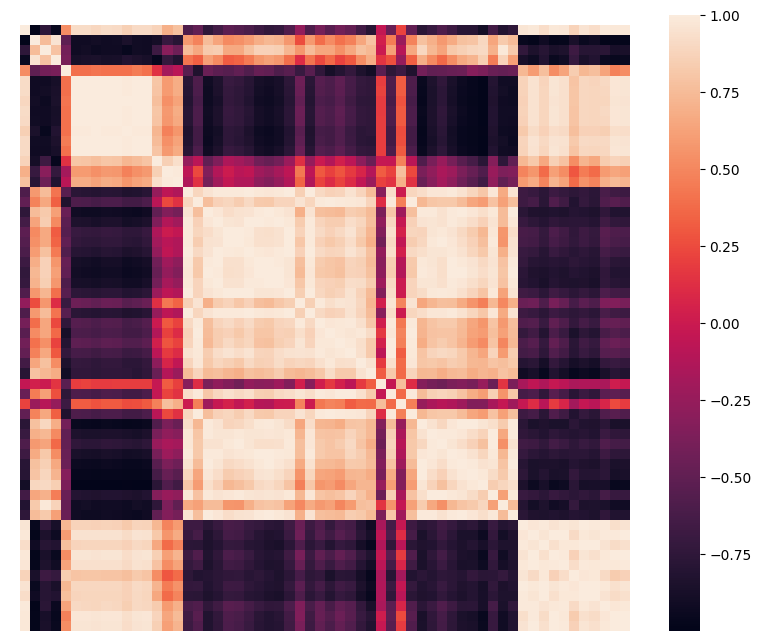

In [10]:
correlation_matrix = selected_countries_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, xticklabels=False, yticklabels=False)
plt.show()

In [19]:
def make_corr_matrix(indicator, group_title, save_image: bool=False):
    """
    Create a correlation plot for a specified indicator and display correlation scores.
    """
    group_columns = selected_countries_df.filter(like=indicator).columns.to_list()
    group_columns.append('Happiness Score')
    group_df = selected_countries_df[group_columns]
    correlation_matrix = group_df.corr()

    fig, ax = plt.subplots(figsize=(14, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, ax=ax)
    ax.set_title(f'Correlation Matrix - {group_title}')

    if save_image:
        plt.savefig(f"../fig/correlation_plot_{group_title}.png")

    plt.show()

# group_indicators = ['1.1.1', '3.4.2', '4.1.2', '8.5.2']
# group_titles = ['Poverty line', 'Suicide mortality rate', 'Completion rate ', 'Unemployment rate']

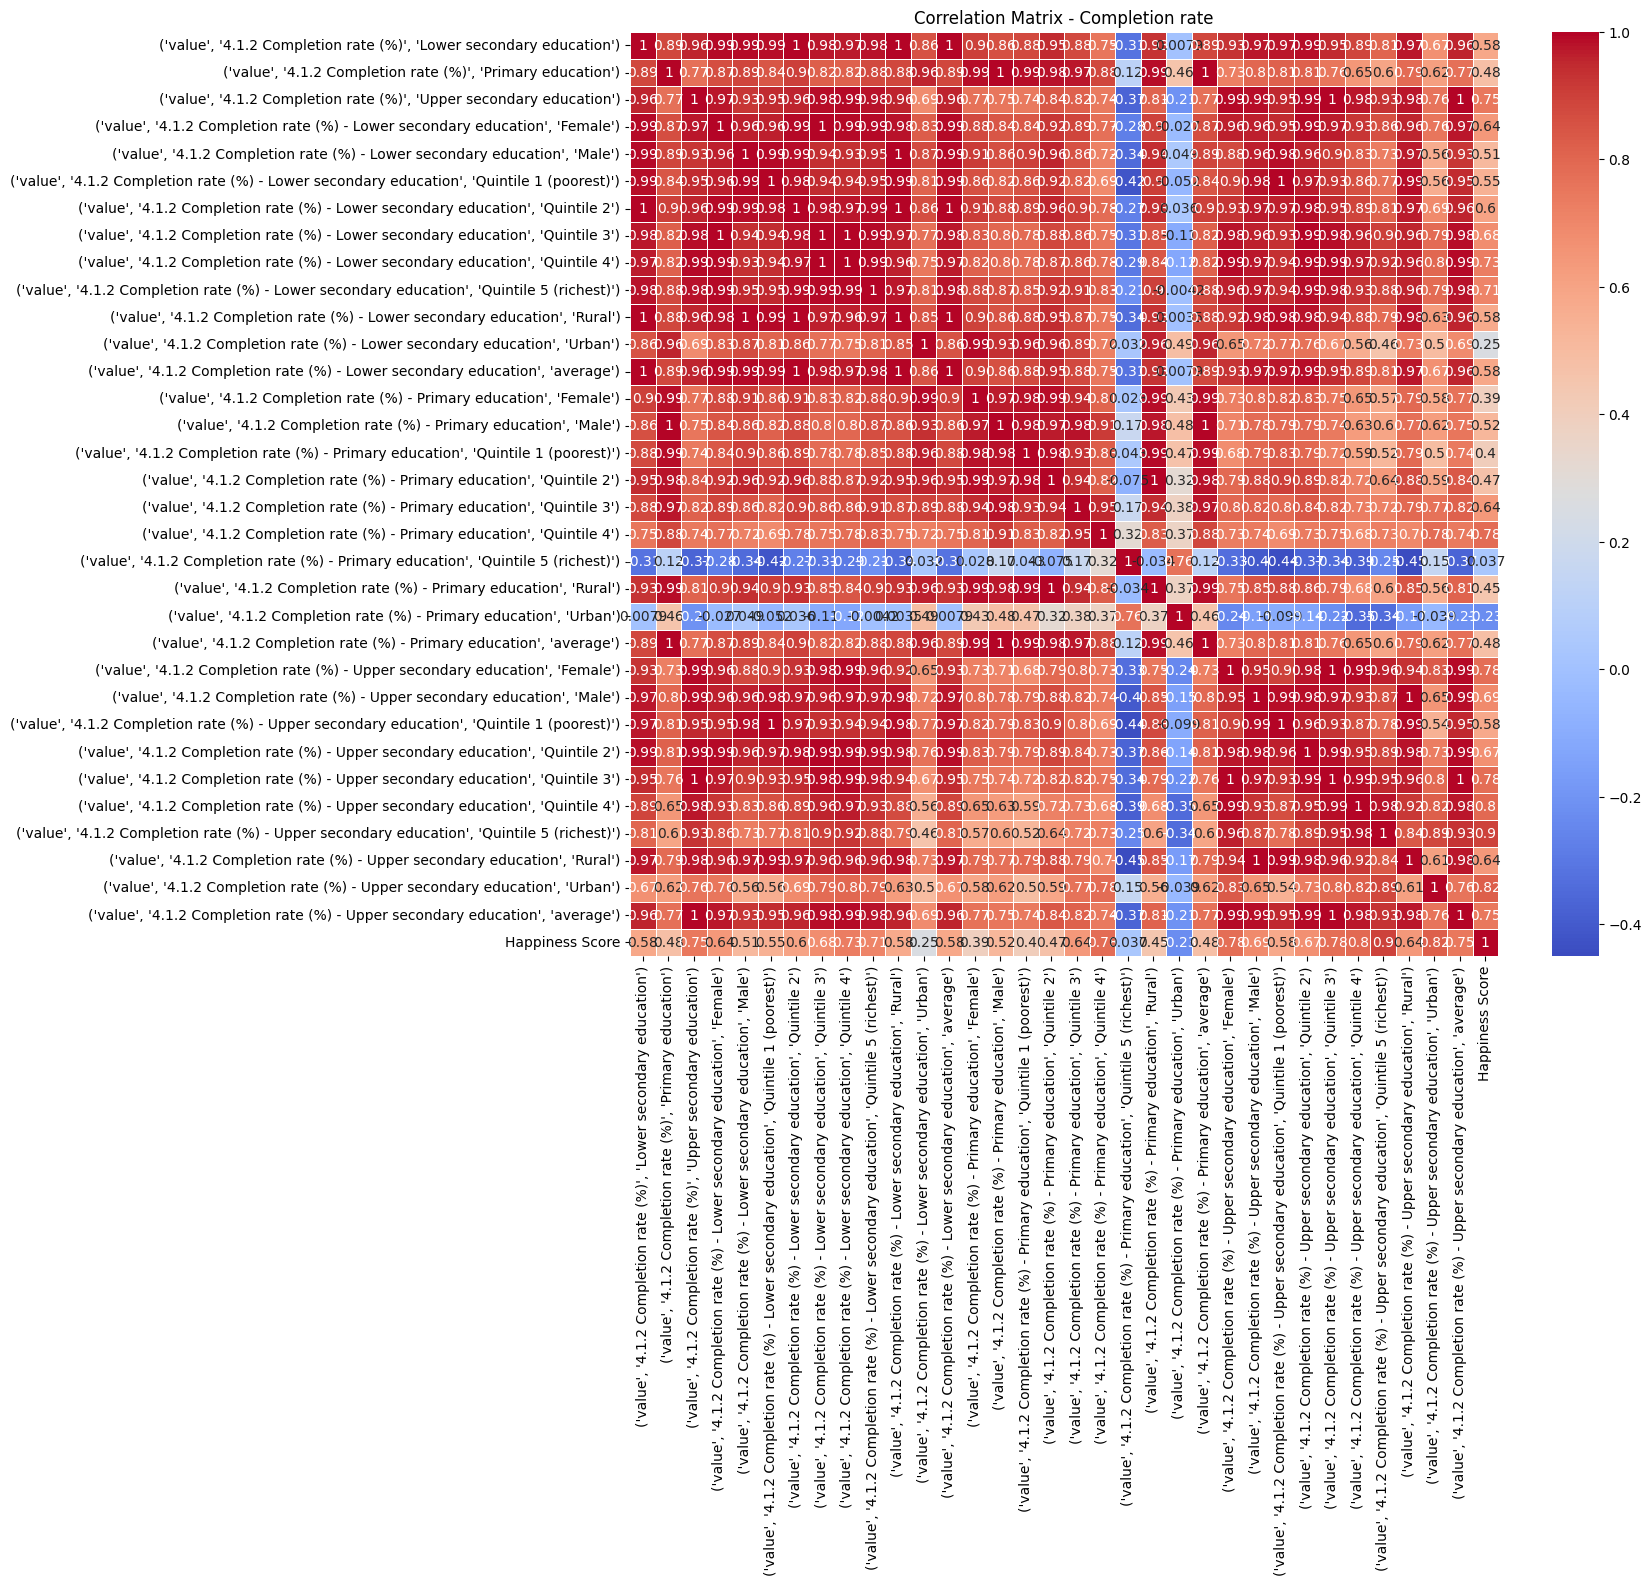

In [20]:
make_corr_matrix('4.1.2', 'Completion rate', save_image=False)

We see above, that subcategories of the same indicator are highly correlated (>0.84) to each other. Now we would like to explore the degree to which the indicators correlate with the Happiness Score.

In [22]:
def indicator_happiness_corr(indicator):
    ### To compute the correlation between columns of indicator and Hapiness Score
    columns = selected_countries_df.filter(like=indicator).columns.tolist()
    columns.append('Happiness Score')
    corr = selected_countries_df[columns].corr()
    return corr['Happiness Score'].sort_values()

The indicator '1.1.1 Population below international poverty line' has a strong negative correlation with Happiness. 

In [23]:
poverty_happiness_corr = indicator_happiness_corr('1.1.1')
print(poverty_happiness_corr)

(value, 1.1.1 Population below international poverty line (%), Female)        -0.916903
(value, 1.1.1 Population below international poverty line (%), 15-64 years)   -0.916595
(value, 1.1.1 Population below international poverty line (%), 65+ years)     -0.915446
(value, 1.1.1 Population below international poverty line (%), average)       -0.914332
(value, 1.1.1 Population below international poverty line (%), Male)          -0.911022
(value, 1.1.1 Population below international poverty line (%), Urban)         -0.909312
(value, 1.1.1 Population below international poverty line (%), <15 years)     -0.898732
(value, 1.1.1 Population below international poverty line (%), Rural)         -0.853324
Happiness Score                                                                1.000000
Name: Happiness Score, dtype: float64


Suicide morality rate also has a strong negative correlation to Hapiness. It is interesting to note that the suicide mortality rate of the Female population exhibits a stronger correlation to Hapiness, despite males having higher suicide mortality rates globally.

In [24]:
suicide_happiness_corr = indicator_happiness_corr('3.4.2')
print(suicide_happiness_corr)

(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Female)    -0.883781
(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), average)   -0.786386
(value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), Male)      -0.703574
Happiness Score                                                                   1.000000
Name: Happiness Score, dtype: float64


The correlation between Happiness Scores and Completion rates are generally positive. The completion of upper secondary education of higher income quintiles shows the highest correlation with happiness, with correlation coefficients greater than 0.75. The completion of primary education in urban areas and among the richest quintile has almost no correlation, which may imply the prevalence of primary education among the rich, who tend to reside in urban areas. 

The completion of Primary education is rather unsignificant, apart from that in Quintile 4. Indicators of this income group may be a proxy for the income distribution equality of the country, as the living conditions of the two upper quintiles may differ significantly in countries with low income parity.

In [25]:
education_happiness_corr = indicator_happiness_corr('4.1.2')
print(education_happiness_corr)

(value, 4.1.2 Completion rate (%) - Primary education, Urban)                          -0.228458
(value, 4.1.2 Completion rate (%) - Primary education, Quintile 5 (richest))            0.036848
(value, 4.1.2 Completion rate (%) - Lower secondary education, Urban)                   0.253234
(value, 4.1.2 Completion rate (%) - Primary education, Female)                          0.388650
(value, 4.1.2 Completion rate (%) - Primary education, Quintile 1 (poorest))            0.399908
(value, 4.1.2 Completion rate (%) - Primary education, Rural)                           0.449977
(value, 4.1.2 Completion rate (%) - Primary education, Quintile 2)                      0.473035
(value, 4.1.2 Completion rate (%), Primary education)                                   0.482041
(value, 4.1.2 Completion rate (%) - Primary education, average)                         0.482041
(value, 4.1.2 Completion rate (%) - Lower secondary education, Male)                    0.510522
(value, 4.1.2 Completion rate 

Unemployment rates demonstrate the strongest correlation to Happiness, out of all the indicator groups. We see a clear trend of Male subcategories showing higher negative correlations (> -0.978), which may imply the prevalence of the 'male breadwinner' culture in the selected countries.

In [26]:
unemployment_happiness_corr = indicator_happiness_corr('8.5.2')
print(unemployment_happiness_corr)

(value, 8.5.2 Unemployment rate (%) - Male, 15-24 years)     -0.987197
(value, 8.5.2 Unemployment rate (%), Male)                   -0.981510
(value, 8.5.2 Unemployment rate (%) - Male, average)         -0.981510
(value, 8.5.2 Unemployment rate (%), 25+ years)              -0.978719
(value, 8.5.2 Unemployment rate (%) - Male, 25+ years)       -0.978639
(value, 8.5.2 Unemployment rate (%), average)                -0.971319
(value, 8.5.2 Unemployment rate (%), 15-24 years)            -0.958704
(value, 8.5.2 Unemployment rate (%) - Female, 25+ years)     -0.948589
(value, 8.5.2 Unemployment rate (%), Female)                 -0.920637
(value, 8.5.2 Unemployment rate (%) - Female, average)       -0.920637
(value, 8.5.2 Unemployment rate (%) - Female, 15-24 years)   -0.860065
Happiness Score                                               1.000000
Name: Happiness Score, dtype: float64


# Vizualizing worldwide correlations

In [27]:
df = pd.read_pickle('../data/combined_df.pkl')

In [28]:
df.columns = df.columns.map(lambda x: ", ".join(x) if isinstance(x, tuple) else x)

In [29]:
def make_corr_plot(df: pd.DataFrame, columns: [str], xlabel: str, ylabel: str, title: str, save: bool=False):
    """
    Makes correlation plot of specified columns and displays correlation score
    """
    # calculate correlation score
    filtered_df = df.dropna(subset=columns)
    
    correlation_coefficient = filtered_df[columns[0]].corr(filtered_df[columns[1]])

    # style choices
    sns.set_style("whitegrid") 
    sns.set_palette("deep")  
    plt.figure(figsize=(8, 6))
    
    # make reg plot
    sns.regplot(x=columns[0], y=columns[1], data=df, 
                scatter_kws={'s': 60, 'alpha': 0.6},
                line_kws={'color':'red'}
               )

    # annotate plot with correlation score
    plt.annotate(f'Correlation: {correlation_coefficient:.2f}', xy=(0.8, 0.85), xycoords='axes fraction', 
                 ha='center', fontsize=10,
                 bbox=dict(boxstyle='round,pad=0.3', edgecolor='steelblue', facecolor='white'))

    # Add labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontweight="bold")
    
    if save:
        plt.savefig(f"../fig/scatter_plot_{title}.png")

    # Show the plot
    plt.show()

In [45]:
scatters = [df.columns[11], df.columns[25], df.columns[28], df.columns[30], df.columns[68]]
print(scatters)

['value, 1.1.1 Employed population below international poverty line (%), average', 'value, 1.1.1 Population below international poverty line (%), average', 'value, 3.4.2 Suicide mortality rate (deaths per 100 000 population), average', 'value, 4.1.2 Completion rate (%), Primary education', 'value, 8.5.2 Unemployment rate (%), average']


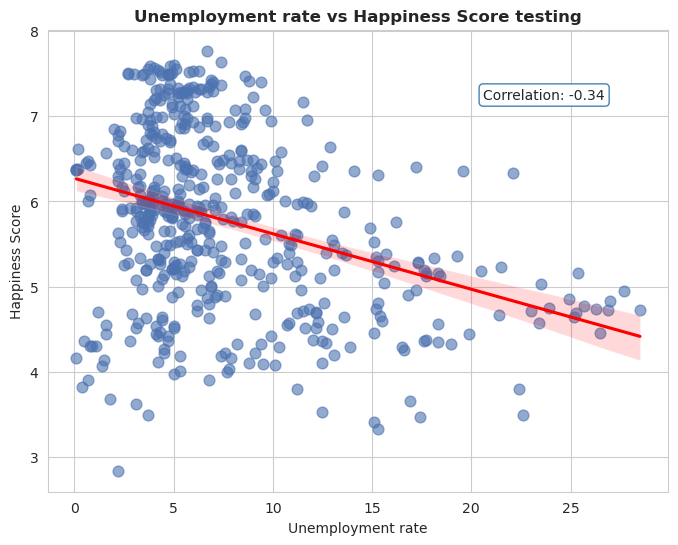

In [41]:
subset_to_scatter = [df.columns[68], df.columns[3]]

make_corr_plot(df, subset_to_scatter, "Unemployment rate", 
               "Happiness Score", 
               "Unemployment rate vs Happiness Score testing",
              save=True)

# Plotting general data on world map

To get an overview vizualization of the happiness scores, poverty rates, unemployment rates and suicide rates of all the countries in our dataset, we can plot them on a map of the world. For this, we use a geom shapefile from the `geopandas` dataset. We then merge this with our data so we can plot the results

In [33]:
import geopandas as gpd

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

/var/folders/jt/d69hwrb156jbgydttvzhcngc0000gn/T/ipykernel_1472/1113910621.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


First, we check again the overlap in the countries columns:

In [34]:
hap_countries = set(happiness["Country"])
gpd_countries = set(countries["name"])
print(len(hap_countries))
print(len(gpd_countries))

print(len(hap_countries.intersection(gpd_countries)))
print(hap_countries.difference(gpd_countries), "\n")
print(gpd_countries.difference(hap_countries))

170
177
145
{'Bahrain', 'Congo (Kinshasa)', 'Hong Kong', 'North Cyprus', 'Somaliland region', 'Taiwan Province of China', 'Somaliland Region', 'Congo (Brazzaville)', 'Bosnia and Herzegovina', 'Hong Kong S.A.R., China', 'Swaziland', 'Palestinian Territories', 'Malta', 'Comoros', 'Macedonia', 'Czech Republic', 'Trinidad & Tobago', 'Dominican Republic', 'Central African Republic', 'Ivory Coast', 'Mauritius', 'Northern Cyprus', 'Singapore', 'United States', 'South Sudan'} 

{'Eritrea', 'United States of America', "Côte d'Ivoire", 'Papua New Guinea', 'Greenland', 'W. Sahara', 'Falkland Is.', 'Bahamas', 'Timor-Leste', 'Fiji', 'Central African Rep.', 'Antarctica', 'Dominican Rep.', 'New Caledonia', 'S. Sudan', 'Eq. Guinea', 'N. Cyprus', 'eSwatini', 'Czechia', 'North Korea', 'Bosnia and Herz.', 'Dem. Rep. Congo', 'Palestine', 'Congo', 'Guyana', 'Guinea-Bissau', 'Brunei', 'Fr. S. Antarctic Lands', 'Vanuatu', 'Somaliland', 'Cuba', 'Solomon Is.'}


Then make a dictionary for the changed names

In [35]:
gpd_country_rename = {
    'Dem. Rep. Congo' : 'Congo (Kinshasa)',
    'Congo' : 'Congo (Brazzaville)',
    'Central African Rep.' : 'Central African Republic',
    'S. Sudan' : 'South Sudan',
    'eSwatini' : 'Swaziland',
    'N. Cyprus' : 'Northern Cyprus',
    'Dominican Rep.' : 'Dominican Republic',
    'Somaliland' : 'Somaliland Region',
    "Côte d'Ivoire" : 'Ivory Coast',
    'United States of America' : 'United States',
    'Czechia' : 'Czech Republic',
    'Bosnia and Herz.' : 'Bosnia and Herzegovina',
    'Palestine' : 'Palestinian Territories',
}

In [36]:
countries['name'] = countries['name'].replace(gpd_country_rename)

hap_countries = set(happiness["Country"])
gpd_countries = set(countries["name"])
print(len(hap_countries.intersection(gpd_countries)))

158


In [58]:
df.rename(columns={df.columns[25]: 'Population below Poverty line',
                   df.columns[28]: 'Suicide Mortality Rate',
                   df.columns[30]: 'Completion Rate',
                   df.columns[68]: 'Unemployment Rate'}, inplace=True)

happiness = happiness.merge(df[['Happiness Score', 'Population below Poverty line', 'Suicide Mortality Rate', 'Completion Rate', 'Unemployment Rate']],
                            on='Happiness Score', how='left')

indicators_grouped = happiness.groupby(['Country']).agg({
    'Happiness Rank': 'mean',
    'Happiness Score': 'mean',
    'Population below Poverty line': 'mean',
    'Suicide Mortality Rate': 'mean',
    'Completion Rate': 'mean',
    'Unemployment Rate': 'mean'
}).reset_index()
indicators_grouped.head()

,Country,Happiness Rank,Happiness Score,Population below Poverty line,Suicide Mortality Rate,Completion Rate,Unemployment Rate
0,Afghanistan,149.4,3.51280,NaN,0.00405,59.142158,11.200000
1,Albania,106.4,4.71260,0.000,0.00455,94.956850,14.000000
2,Algeria,66.2,5.66760,NaN,0.00260,96.140002,11.666667
3,Angola,140.0,3.87225,31.100,0.00650,56.268550,NaN
4,Argentina,31.2,6.45940,0.675,0.00835,96.038002,9.133333


In [59]:
countries = countries.rename(columns={"name": "Country"})
countries.head()

,pop_est,continent,Country,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [60]:
merged_df = pd.merge(countries, indicators_grouped, on='Country', how='left')
merged_df.head()

,pop_est,continent,Country,iso_a3,gdp_md_est,geometry,Happiness Rank,Happiness Score,Population below Poverty line,Suicide Mortality Rate,Completion Rate,Unemployment Rate
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN,NaN,NaN
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",152.694444,3.325639,44.900002,0.004250,74.144086,NaN
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN,NaN
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",8.694444,7.288083,NaN,0.008297,NaN,5.566667
4,328239523.0,North America,United States,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",15.111111,7.102306,0.700000,0.014500,99.672455,5.491667


Now we can plot the happiness rank on the world map

In [73]:
def generate_world_map(column):
    """
    Generate a world map based on a specified column.
    """
    merged_df.plot(column=column, 
                   legend=True,
                   legend_kwds={"label": column, "orientation": "vertical", 'shrink': 0.5},
                   cmap="RdYlGn",
                   missing_kwds={
                       "color": "lightgrey",
                       "hatch": "///",
                       "label": "No data",
                   })

    plt.title("World Map - " + column)
    plt.axis('off')

    plt.figure(figsize=(24, 18))

    # Save the world map as an image
    plt.savefig(f"../fig/world_{column}_map.png", format='png')

    # Display the world map
    plt.show()

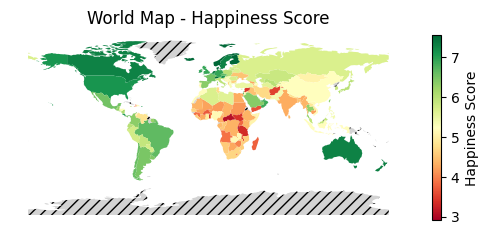

<Figure size 2400x1800 with 0 Axes>

In [74]:
generate_world_map('Happiness Score')

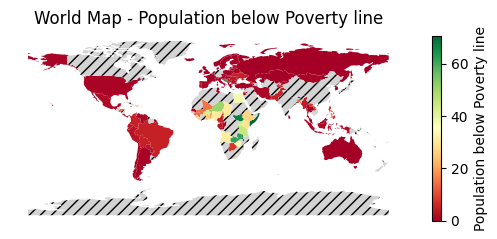

<Figure size 2000x1500 with 0 Axes>

In [65]:
generate_world_map('Population below Poverty line')

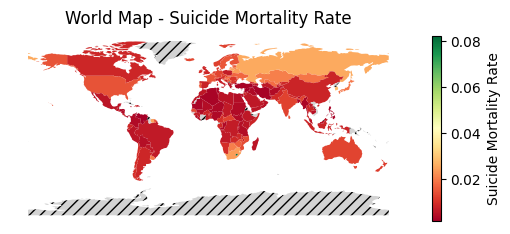

<Figure size 2000x1500 with 0 Axes>

In [67]:
generate_world_map('Suicide Mortality Rate')

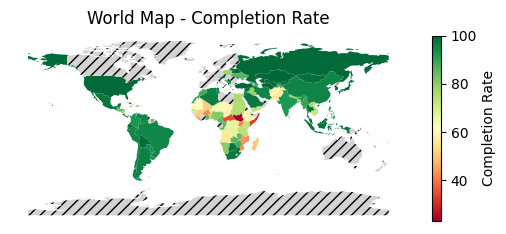

<Figure size 2000x1500 with 0 Axes>

In [68]:
generate_world_map('Completion Rate')

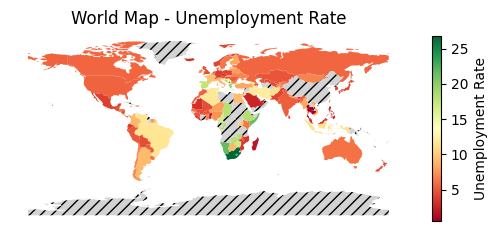

<Figure size 2000x1500 with 0 Axes>

In [69]:
generate_world_map('Unemployment Rate')